## Problem 1.3

In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import DataFrame
from sklearn.linear_model import LinearRegression

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
def input_calculate_data(hashtag):
    hashtag_map = {'#GoHawks' : ['tweets_#gohawks.txt', 188136],
                    '#GoPatriots' : ['tweets_#gopatriots.txt', 26232],
                    '#NFL' : ['tweets_#nfl.txt', 259024],
                    '#Patriots' : ['tweets_#patriots.txt', 489713],
                    '#SB49' : ['tweets_#sb49.txt', 826951],
                    '#SuperBowl' : ['tweets_#superbowl.txt', 1348767]}
      
    time_stamps = [0]*hashtag_map[hashtag][1]
    retweet = [False]*hashtag_map[hashtag][1]
    followers_of_users = [0]*hashtag_map[hashtag][1]
    number_of_url = [0]*hashtag_map[hashtag][1]
    author_names = ['']*hashtag_map[hashtag][1]
    number_of_mentions = [0]*hashtag_map[hashtag][1]
    ranking_scores = [0.0]*hashtag_map[hashtag][1]
    
    file = open('./tweet_data/'+hashtag_map[hashtag][0])
    for (line, index) in zip(file, range(0, hashtag_map[hashtag][1])):
        data = json.loads(line)
        time_stamps[index] = data['citation_date']
        followers_of_users[index] = data['author']['followers']

        author_name = data['author']['nick']
        original_author_name = data['original_author']['nick']
        if author_name != original_author_name:
            retweet[index] = True

        number_of_url[index] = len(data['tweet']['entities']['urls'])
        author_names[index] = author_name
        number_of_mentions[index] = len(data['tweet']['entities']['user_mentions'])
        ranking_scores[index] = data['metrics']['ranking_score']
                
    file.close()

    hours_passed = int((max(time_stamps)-min(time_stamps))/3600)+1
    hourly_tweets = [0] * hours_passed
    hourly_retweets = [0] * hours_passed
    hourly_followers = [0] * hours_passed
    hourly_max_followers = [0] * hours_passed
    hourly_time_of_the_day = [0] * hours_passed    
    hourly_url = [0] * hours_passed
    hourly_authors = [0] * hours_passed
    hourly_author_set = [0] * hours_passed
    for i in range(0, hours_passed):
        hourly_author_set[i] = set([])
    hourly_mentions = [0] * hours_passed
    hourly_ranking_scores = [0.0] * hours_passed
    
    start_time = min(time_stamps)
    for i in range(0, hashtag_map[hashtag][1]):
        current = int((time_stamps[i]-start_time)/3600)
        
        hourly_tweets[current] += 1
        if retweet[i]:
            hourly_retweets[current] += 1
                                      
        hourly_followers[current] += followers_of_users[i]   
        if followers_of_users[i] > hourly_max_followers[current]:
            hourly_max_followers[current] = followers_of_users[i]


        hourly_url[current] += number_of_url[i]
        hourly_author_set[current].add(author_names[i])
        hourly_mentions[current] += number_of_mentions[i]
        hourly_ranking_scores[current] += ranking_scores[i]

    for i in range(0, len(hourly_author_set)):
        hourly_authors[i] = len(hourly_author_set[i])
    
    for i in range(0, len(hourly_time_of_the_day)):
        hourly_time_of_the_day[i] = i%24

    target_value = hourly_tweets[1:]
    target_value.append(0)
    data = np.array([hourly_tweets, hourly_retweets, hourly_followers, hourly_max_followers, hourly_time_of_the_day,
                     hourly_url, hourly_authors, hourly_mentions, hourly_ranking_scores, target_value])
    data = np.transpose(data)
    df = DataFrame(data)
    df.columns = ['Total_num_tweets', 'Toatl_num_retweets', 'Total_num_followers', 'Max_followers', 'time_of_day', 
                  'Total_num_url','Total_num_authors', 'Total_num_mentions', 'Total_ranking_score', 'target_data']
    df.to_csv('./Data_info/'+hashtag+'.csv', index = False)

In [9]:
def plot_help(training, prediction):
    fig, ax = plt.subplots()
    ax.scatter(training['Toatl_num_retweets'], prediction)
    ax.set_xlabel('Actual Number of Tweets')
    ax.set_ylabel('Predicted value')
    plt.title('Predicted value vs Actual Number of Tweets')
    plt.show()
    fig, ax = plt.subplots()
    ax.scatter(training['Total_num_authors'], prediction)
    ax.set_xlabel('Actual Number of Authors')
    ax.set_ylabel('Predicted value')
    plt.title('Predicted value vs Actual Number of Authors')
    plt.show()
    fig, ax = plt.subplots()
    ax.scatter(training['Total_ranking_score'], prediction)
    ax.set_xlabel('Actual Ranking Scores')
    ax.set_ylabel('Predicted value')
    plt.title('Predicted value vs Actual Ranking Scores')
    plt.show()

In [10]:
def linear_regression(hashtag):
    training_data = pd.read_csv('./Data_info/'+hashtag+'.csv')
    time_of_days = range(0,24)
    for time_of_day in time_of_days:
        tod_data = []
        for tod in training_data['time_of_day']:
            if tod == time_of_day:
                tod_data.append(1)
            else:
                tod_data.append(0)
          
    training_data.drop('time_of_day', 1, inplace = True)
    target_data = training_data.pop('target_data')  
    lr = LinearRegression(fit_intercept = False)
    lr_result = lr.fit(training_data, target_data)
    prediction = lr_result.predict(training_data)   
    results = sm.OLS(target_data, training_data).fit()
    print(results.summary())
    plot_help(training_data, prediction)


Hashtag: #GoHawks
                            OLS Regression Results                            
Dep. Variable:            target_data   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     180.7
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          5.43e-151
Time:                        22:23:33   Log-Likelihood:                -4638.5
No. Observations:                 579   AIC:                             9293.
Df Residuals:                     571   BIC:                             9328.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Total_num_tweets

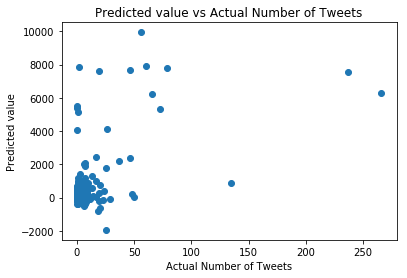

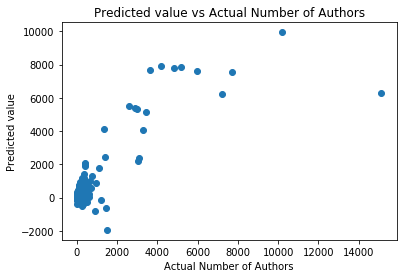

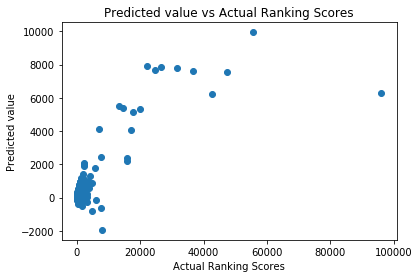

Hashtag: #GoPatriots
                            OLS Regression Results                            
Dep. Variable:            target_data   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     535.4
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          1.46e-258
Time:                        22:23:36   Log-Likelihood:                -3499.9
No. Observations:                 575   AIC:                             7016.
Df Residuals:                     567   BIC:                             7051.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Total_num_twe

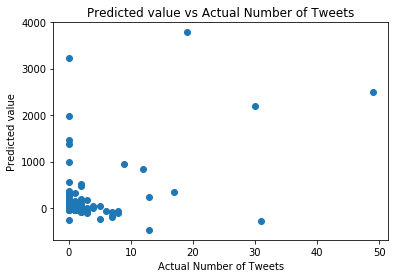

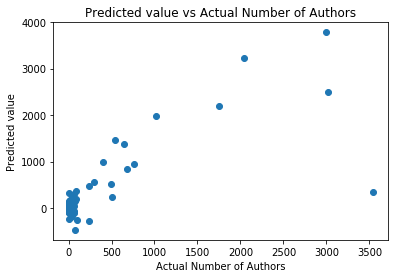

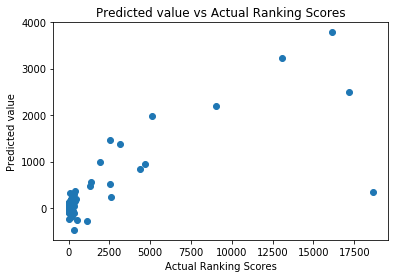

Hashtag: #NFL
                            OLS Regression Results                            
Dep. Variable:            target_data   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     189.9
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          1.99e-156
Time:                        22:23:56   Log-Likelihood:                -4500.7
No. Observations:                 587   AIC:                             9017.
Df Residuals:                     579   BIC:                             9052.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Total_num_tweets    

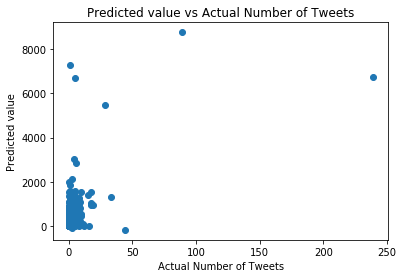

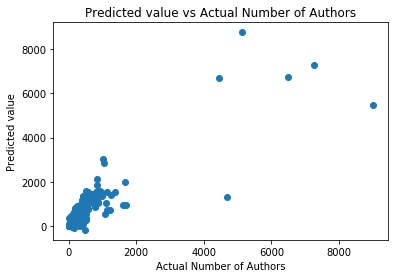

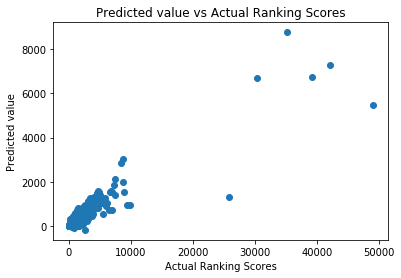

Hashtag: #Patriots
                            OLS Regression Results                            
Dep. Variable:            target_data   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     280.0
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          2.07e-193
Time:                        22:24:31   Log-Likelihood:                -5299.7
No. Observations:                 587   AIC:                         1.062e+04
Df Residuals:                     579   BIC:                         1.065e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Total_num_tweet

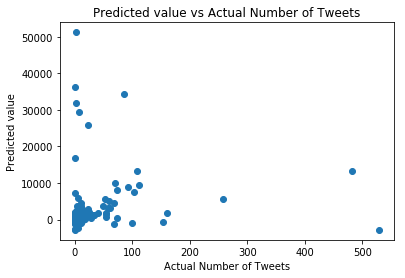

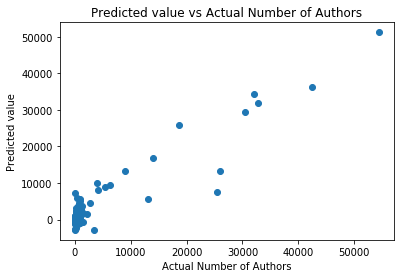

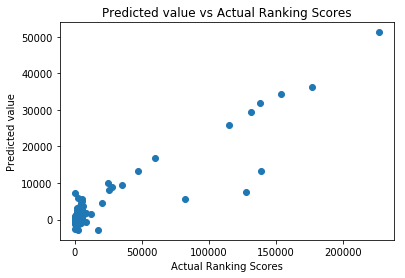

Hashtag: #SB49
                            OLS Regression Results                            
Dep. Variable:            target_data   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     617.6
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          1.41e-276
Time:                        22:25:31   Log-Likelihood:                -5545.4
No. Observations:                 583   AIC:                         1.111e+04
Df Residuals:                     575   BIC:                         1.114e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Total_num_tweets   

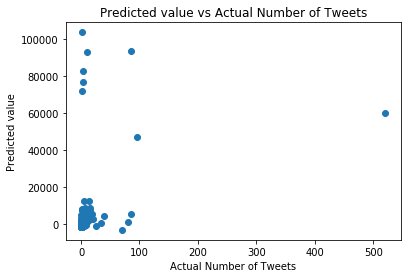

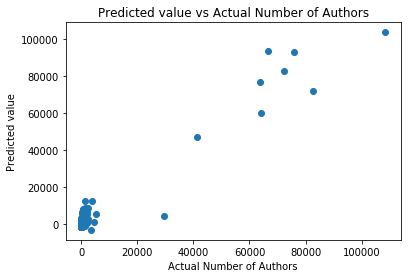

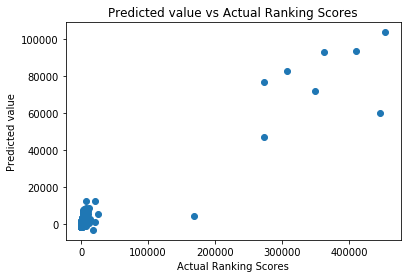

Hashtag: #SuperBowl
                            OLS Regression Results                            
Dep. Variable:            target_data   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1056.
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:27:16   Log-Likelihood:                -5768.1
No. Observations:                 586   AIC:                         1.155e+04
Df Residuals:                     578   BIC:                         1.159e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Total_num_twee

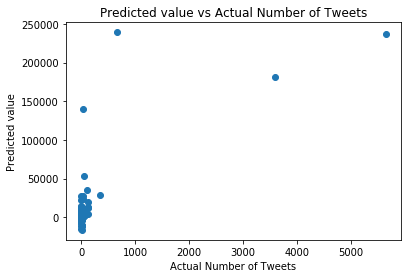

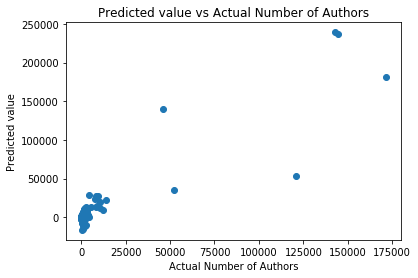

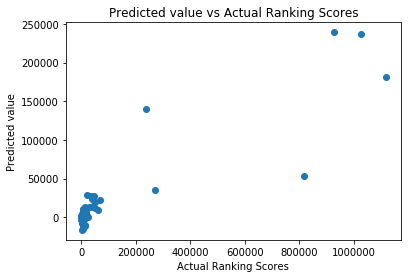

In [11]:
hashtags = ['#GoHawks', '#GoPatriots', '#NFL', '#Patriots', '#SB49', '#SuperBowl']
for ht in hashtags:
    print ('Hashtag: ' + ht)
    input_calculate_data(ht)
    linear_regression(ht)

## Problem 1.4

In [12]:
from sklearn.cross_validation import cross_val_predict
from sklearn.ensemble import RandomForestRegressor

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
def input_calculate_data_2(hashtag):
    hashtag_map = {'#GoHawks' : ['tweets_#gohawks.txt', 188136],
                    '#GoPatriots' : ['tweets_#gopatriots.txt', 26232],
                    '#NFL' : ['tweets_#nfl.txt', 259024],
                    '#Patriots' : ['tweets_#patriots.txt', 489713],
                    '#SB49' : ['tweets_#sb49.txt', 826951],
                    '#SuperBowl' : ['tweets_#superbowl.txt', 1348767]}
      
    time_stamps = [0]*hashtag_map[hashtag][1]
    retweet = [False]*hashtag_map[hashtag][1]
    followers_of_users = [0]*hashtag_map[hashtag][1]
    number_of_url = [0]*hashtag_map[hashtag][1]
    author_names = ['']*hashtag_map[hashtag][1]
    number_of_mentions = [0]*hashtag_map[hashtag][1]
    ranking_scores = [0.0]*hashtag_map[hashtag][1]
    file = open('./tweet_data/'+hashtag_map[hashtag][0])
    
    for (line, index) in zip(file, range(0, hashtag_map[hashtag][1])):
        data = json.loads(line)
        time_stamps[index] = data['citation_date']
        followers_of_users[index] = data['author']['followers']

        author_name = data['author']['nick']
        original_author_name = data['original_author']['nick']
        if author_name != original_author_name:
            retweet[index] = True

        number_of_url[index] = len(data['tweet']['entities']['urls'])
        author_names[index] = author_name
        number_of_mentions[index] = len(data['tweet']['entities']['user_mentions'])
        ranking_scores[index] = data['metrics']['ranking_score']
                
    file.close()

    hours_passed = int((max(time_stamps)-1421222400)/3600)+1
    hourly_tweets = [0] * hours_passed
    hourly_retweets = [0] * hours_passed
    hourly_followers = [0] * hours_passed
    hourly_max_followers = [0] * hours_passed
    hourly_time_of_the_day = [0] * hours_passed    
    hourly_url = [0] * hours_passed
    hourly_authors = [0] * hours_passed
    hourly_author_set = [0] * hours_passed
    for i in range(0, hours_passed):
        hourly_author_set[i] = set([])
    hourly_mentions = [0] * hours_passed
    hourly_ranking_scores = [0.0] * hours_passed
    
    start_time = 1421222400
    for i in range(0, hashtag_map[hashtag][1]):
        current = int((time_stamps[i]-start_time)/3600)
        
        hourly_tweets[current] += 1
        if retweet[i]:
            hourly_retweets[current] += 1
                                      
        hourly_followers[current] += followers_of_users[i]   
        if followers_of_users[i] > hourly_max_followers[current]:
            hourly_max_followers[current] = followers_of_users[i]


        hourly_url[current] += number_of_url[i]
        hourly_author_set[current].add(author_names[i])
        hourly_mentions[current] += number_of_mentions[i]
        hourly_ranking_scores[current] += ranking_scores[i]

    for i in range(0, len(hourly_author_set)):
        hourly_authors[i] = len(hourly_author_set[i])
    
    for i in range(0, len(hourly_time_of_the_day)):
        hourly_time_of_the_day[i] = i%24

    target_value = hourly_tweets[1:]
    target_value.append(0)
    data = np.array([hourly_tweets, hourly_retweets, hourly_followers, hourly_max_followers, hourly_time_of_the_day,
                     hourly_url, hourly_authors, hourly_mentions, hourly_ranking_scores, target_value])
    data = np.transpose(data)
    df = DataFrame(data)
    df.columns = ['Total_num_tweets', 'Toatl_num_retweets', 'Total_num_followers', 'Max_followers', 'time_of_day', 
                  'Total_num_url','Total_num_authors', 'Total_num_mensions', 'Total_ranking_score', 'target_data']
    df.to_csv('./Data_info_2/'+hashtag+'.csv', index = False)  

In [14]:
def pre_error(target, prediction):
    error = 0.0
    for (actual, pre) in zip(target, prediction):
        error += abs(actual - pre)
    print(error/len(target))

In [15]:
def cv_error(hashtag):
    training_data = pd.read_csv('./Data_info_2/'+hashtag+'.csv')
      
    time_of_days = range(0,24)
    for time_of_day in time_of_days:
        tod_data = []
        for tod in training_data['time_of_day']:
            if tod == time_of_day:
                tod_data.append(1)
            else:
                tod_data.append(0) 
    training_data.drop('time_of_day', 1, inplace = True)
    target_data = training_data.pop('target_data') 
    training_data_1 = training_data[:440]
    training_data_2 = training_data[440:452]
    training_data_3 = training_data[452:]       
    target_data_1 = target_data[:440]
    target_data_2 = target_data[440:452]
    target_data_3 = target_data[452:]      
    lr_1 = RandomForestRegressor(n_estimators = 20) 
    lr_2 = RandomForestRegressor(n_estimators = 20)
    lr_3 = RandomForestRegressor(n_estimators = 20)
    
    cv_1= cross_val_predict(lr_1, training_data_1, target_data_1, cv = 10)
    cv_2 = cross_val_predict(lr_2, training_data_2, target_data_2, cv = 10)
    cv_3 = cross_val_predict(lr_3, training_data_3, target_data_3, cv = 10)

    print(hashtag)
    print ('Average cross-validation error before Feb. 1, 8:00 a.m.:')
    pre_error(target_data_1,cv_1)
    print ('Average cross-validation error between Feb. 1, 8:00 a.m. and 8:00 p.m.:')
    pre_error(target_data_2,cv_2)
    print ('Average cross-validation error after Feb. 1, 8:00 p.m.:')
    pre_error(target_data_3,cv_3)
    print ('')

In [16]:
hashtags = ['#GoHawks', '#GoPatriots', '#NFL', '#Patriots', '#SB49', '#SuperBowl']
for ht in hashtags:
    input_calculate_data_2(ht)
    cv_error(ht)

#GoHawks
Average cross-validation error before Feb. 1, 8:00 a.m.:
161.829545455
Average cross-validation error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
2178.84583333
Average cross-validation error after Feb. 1, 8:00 p.m.:
25.1785139216

#GoPatriots
Average cross-validation error before Feb. 1, 8:00 a.m.:
11.3729730801
Average cross-validation error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
863.7
Average cross-validation error after Feb. 1, 8:00 p.m.:
3.90292576576

#NFL
Average cross-validation error before Feb. 1, 8:00 a.m.:
117.166363636
Average cross-validation error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
2892.39583333
Average cross-validation error after Feb. 1, 8:00 p.m.:
157.291111111

#Patriots
Average cross-validation error before Feb. 1, 8:00 a.m.:
200.992045455
Average cross-validation error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
17718.8666667
Average cross-validation error after Feb. 1, 8:00 p.m.:
111.656666667

#SB49
Average cross-validation error before Feb. 1, 8:00 a.m

### Aggregate the data of all hashtags

In [17]:
training_data = None
hashtags = ['#GoHawks', '#GoPatriots', '#NFL', '#Patriots', '#SB49', '#SuperBowl']
for ht in hashtags:
    ht_data = pd.read_csv('./Data_info_2/'+ht+'.csv')
    training_data = pd.concat([training_data, ht_data])

In [18]:
time_of_days = range(0,24)
for time_of_day in time_of_days:
    tod_data = []
    for tod in training_data['time_of_day']:
        if tod == time_of_day:
            tod_data.append(1)
        else:
            tod_data.append(0)

training_data.drop('time_of_day', 1, inplace = True)
target_data = training_data.pop('target_data') 
training_data_1 = training_data[:440]
training_data_2 = training_data[440:452]
training_data_3 = training_data[452:]       
target_data_1 = target_data[:440]
target_data_2 = target_data[440:452]
target_data_3 = target_data[452:]      
lr_1 = RandomForestRegressor(n_estimators = 20) 
lr_2 = RandomForestRegressor(n_estimators = 20)
lr_3 = RandomForestRegressor(n_estimators = 20)

cv_1= cross_val_predict(lr_1, training_data_1, target_data_1, cv = 10)
cv_2 = cross_val_predict(lr_2, training_data_2, target_data_2, cv = 10)
cv_3 = cross_val_predict(lr_3, training_data_3, target_data_3, cv = 10)

print ('Aggregated the data of all hashtags:')
print ('Average cross-validation error before Feb. 1, 8:00 a.m.:')
pre_error(target_data_1,cv_1)
print ('Average cross-validation error between Feb. 1, 8:00 a.m. and 8:00 p.m.:')
pre_error(target_data_2,cv_2)
print ('Average cross-validation error after Feb. 1, 8:00 p.m.:')
pre_error(target_data_3,cv_3)
print ('')

Aggregated the data of all hashtags:
Average cross-validation error before Feb. 1, 8:00 a.m.:
154.474204545
Average cross-validation error between Feb. 1, 8:00 a.m. and 8:00 p.m.:
1987.775
Average cross-validation error after Feb. 1, 8:00 p.m.:
719.601462107

